# Improved U-net Prediction

## Introduction

### Connecting to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the libraries

In [ ]:
import os
import numpy as np
import gc #garbage collector
import random

from tqdm.notebook import tqdm #progress bar

from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import plot_model

### Defining global variables

In [ ]:
IM_HEIGHT = 256
IM_WIDTH = 256

## Modeling

### Defining the model (U-net)

In [ ]:
## 2D two Convolution layer block
def Conv2D_block(input_tensor, n_filters, kernel_size, batchnorm): #Function to add 2 convolutional layers
    #Convolution layer - 1
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)

    #Convolution layer - 2
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)

    return x

In [ ]:
#Unet Architecture
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=False):
    #Encoder Path || Contractor Path
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    # p1 = Dropout(dropout)(p1)

    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    # p2 = Dropout(dropout)(p2)

    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    # p3 = Dropout(dropout)(p3)

    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    # p4 = Dropout(dropout)(p4)

    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)


    #Decoder Path  || Expansion Path
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    # u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    # u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    # u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    # u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)

    #final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

### Defining the model (Improved U-net)

In [ ]:
## 2D two Convolution layer block
def improved_Conv2D_block(input_tensor, n_filters, conv_number, kernel_size=3, batchnorm=True): #Function to add 2 convolutional layers
    # Convolution layer
    for conv in range(conv_number):
      x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same', activation='relu')(input_tensor)
      if batchnorm:
        x = BatchNormalization()(x)
      input_tensor = x

    return x

In [ ]:
#Unet Architecture
def improved_unet(input_image, n_filters=16, kernel_size=3, dropout=0.2, batchnorm=True):
    #Encoder Path || Contractor Path
    c1 = improved_Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm, conv_number=1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = improved_Conv2D_block(p1, (n_filters * 2), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = improved_Conv2D_block(p2, (n_filters * 4), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = improved_Conv2D_block(p3, (n_filters * 8), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=3)

    #Decoder Path  || Expansion Path
    u5 = Conv2DTranspose((n_filters * 4), (kernel_size, kernel_size), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    u5 = Dropout(dropout)(u5)
    c5 = improved_Conv2D_block(u5, (n_filters * 4), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)

    u6 = Conv2DTranspose((n_filters * 2), (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    u6 = Dropout(dropout)(u6)
    c6 = improved_Conv2D_block(u6, (n_filters * 2), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)

    u7 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    u7 = Dropout(dropout)(u7)

    c7 = improved_Conv2D_block(u7, n_filters, kernel_size = kernel_size, batchnorm = batchnorm, conv_number=1)

    #final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c7)
    model = Model(inputs=[input_image], outputs=[output])
    return model

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)

  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred): #Jaccard
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

  return intersection/union

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))

  return true_negatives / (possible_negatives + K.epsilon())

## Results

In [ ]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, dice_coef, SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5)]

#initialize params
n_filters = 32
kernel_size = 5
dropout = 0.05
batch_size = 32
epochs = 20
optimizer = Adam()

#Loading converted images into arrays

# X = np.load("/content/drive/MyDrive/skin_cancer/assets/true_dataset/img_dataset/numpy_dataset/task1/x_train.npy")
# y = np.load("/content/drive/MyDrive/skin_cancer/assets/true_dataset/img_dataset/numpy_dataset/task1/y_train.npy")

# X_valid = np.load("/content/drive/MyDrive/skin_cancer/assets/true_dataset/img_dataset/numpy_dataset/task1/x_valid.npy")
# y_valid = np.load("/content/drive/MyDrive/skin_cancer/assets/true_dataset/img_dataset/numpy_dataset/task1/y_valid.npy")

a = "attribute_globules"

X = np.load(f"/content/drive/MyDrive/skin_cancer/assets/utils/sandbox_3/{a}/npy/ISIC2018_Task1-2_Training_Input.npy")
y = np.load(f"/content/drive/MyDrive/skin_cancer/assets/utils/sandbox_3/{a}/npy/ISIC2018_Task2_Training_GroundTruth_v3.npy")

X_valid = np.load(f"/content/drive/MyDrive/skin_cancer/assets/utils/sandbox_3/{a}/npy/ISIC2018_Task1-2_Validation_Input.npy")
y_valid = np.load(f"/content/drive/MyDrive/skin_cancer/assets/utils/sandbox_3/{a}/npy/ISIC2018_Task2_Validation_GroundTruth.npy")

In [ ]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, dice_coef, SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5)]

# create model
model = improved_unet(input_img, num_filters=n_filters, kernel_size=kernel_size, dropout=dropout, batchnorm=True)
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
# Carrega os pesos
model.load_weights('/content/drive/MyDrive/skin_cancer/models/unet/assets/new_unet_32_5_32_20_vgg16.h5')

In [ ]:
model.summary()

In [ ]:
plot_model(model, "my_first_model.png")

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)

4/4 [==============================] - 195s 44s/step - loss: 0.2857 - accuracy: 0.0000e+00 - precision_4: 0.8699 - recall_4: 0.7957 - iou: 0.5337 - dice_coef: 0.6958 - sensitivity_at_specificity_4: 0.9760 - specificity_at_sensitivity_4: 0.9975


[0.2857464849948883,
 0.0,
 0.8699014782905579,
 0.7956976294517517,
 0.5337057113647461,
 0.695789098739624,
 0.9759920835494995,
 0.9975018501281738]

In [ ]:
preds_val = model.predict(X_valid, verbose=1)
preds_val_t = (preds_val > 0.76).astype(np.uint8)

1/1 [==============================] - 2s 2s/step


In [ ]:
def plot_sample_results(X, y, preds, binary_preds, has_mask):
    ix = random.randint(0, len(X))

    print(f"ix: {ix}")

    fig, ax = plt.subplots(1, 4, figsize=(20,10))

    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[0].set_title('real mask')

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[1].set_title('cancer Predicted')

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('cancer Predicted Binary')

    ax[3].imshow(X[ix])
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='#00FF00', levels=[0.5])
    ax[3].contour(binary_preds[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('cancer')

ix: 39


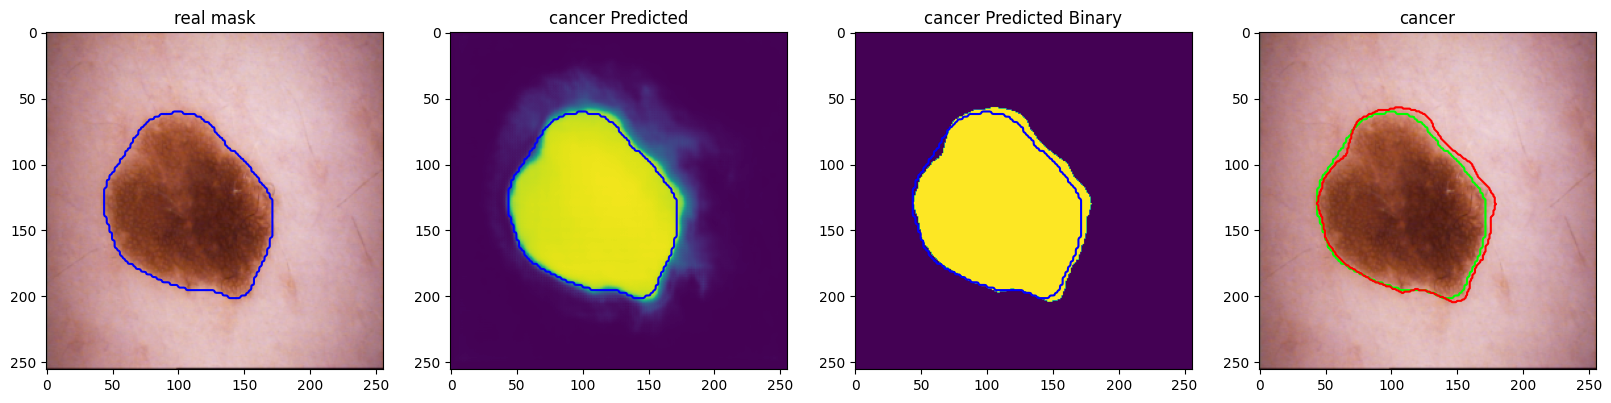

In [ ]:
## Predictions on Test Set
plot_sample_results(X=X_valid, y=y_valid, preds=preds_val, binary_preds=preds_val_t, has_mask=True)